# <p style="text-align: center;"> Demo of GANs </p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing
import deepchem

from gandy.models import gans

In [2]:
deepchem.__version__

'2.5.0.dev'

# <p style="text-align: center;"> A regression task, using the boston dataset </p>

## <p style="text-align: center;"> Get Data </p>

In [3]:
# load data
Xs, Ys = sklearn.datasets.load_boston(return_X_y=True)
Xs_train, Xs_test, Ys_train, Ys_test = sklearn.model_selection.train_test_split(Xs, Ys,
                                                                                train_size=0.8,
                                                                                random_state=42)

# normalize x
x_norm = sklearn.preprocessing.Normalizer()
Xs_train = x_norm.fit_transform(Xs_train)
Xs_test = x_norm.transform(Xs_test)

In [4]:
# # normalizing y to get standardize uncertainties
# y_norm = sklearn.preprocessing.Normalizer()
# Ys_train = y_norm.fit_transform(Ys_train.reshape(1, -1))
# Ys_test = y_norm.transform(Ys_test.reshape(1, -1))

# # transposing to get batch as zeroth dimension
# Ys_train = Ys_train.T
# Ys_test = Ys_test.T

In [5]:
SCALE = np.max(Ys_train)
Ys_train = Ys_train.reshape(-1, 1)/SCALE
Ys_test = Ys_test.reshape(-1, 1)/SCALE

In [6]:
xshape = (Xs_train.shape[1],)  # remove zero dimension
print(xshape)
yshape = (Ys_train[1].shape)  # regression
print(yshape)

(13,)
(1,)


## <p style="text-align: center;"> Initialize Model </p>

###  <p style="text-align: center;">Hyperparam options! </p>

### Below are the defaults for

#### GAN stuff:
- ```noise_shape=(10,)```
- ```conditional=true```


### *ALL HYPERPARMS BELOW MUST START WITH*
```generator_``` or ```discriminator_```

#### Network architecture:

- ```layer_dimensions=[128]```
- ```dropout=0.05```


#### Layer kwargs:

- ```activation='relu'```
- ```use_bias=True```
- ```kernel_initializer="glorot_uniform"```
- ```bias_initializer="zeros"```
- ```kernel_regularizer='l2'```
- ```bias_regularizer=None```
- ```activity_regularizer=None```
- ```kernel_constraint=None```
- ```bias_constraint=None```


In [7]:
# todo why specifying learning rate make non nan loss
GAN = gans.GAN(xshape=xshape, yshape=yshape, noise_shape=(5,), learning_rate=5e-5)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\gandy\models\dcgan.py:99: UserWarning: learning_rate must start with generator_ or discriminator_
Passing learning_rate as deepchem model init kwargs.
  f"\nPassing {key} as deepchem model init kwargs.")


## <p style="text-align: center;"> Train! </p>

###  <p style="text-align: center;">Hyperparam options</p>

#### Training:
- ```batches=50```

    (Number of batches of bootstrapped data, e.g., epochs, to train on)

In [8]:
GAN._model.batch_size # this is automaticaally baked into deepchem

100

In [9]:
GAN.train(Xs_train, Ys_train, batches=50000)

Step 1000: 	Avg gen loss 0.7005653661489487, 	Avg discrim loss 1.383721974015236
Step 2000: 	Avg gen loss 0.693137822508812, 	Avg discrim loss 1.3862176498174668
Step 3000: 	Avg gen loss 0.6937075527310371, 	Avg discrim loss 1.3853041270971298
Step 4000: 	Avg gen loss 0.6936965492963791, 	Avg discrim loss 1.3848481284379959
Step 5000: 	Avg gen loss 0.6945666595101356, 	Avg discrim loss 1.3845019186735152
Step 6000: 	Avg gen loss 0.6943578138947487, 	Avg discrim loss 1.3843441988229752
Step 7000: 	Avg gen loss 0.6943096024394035, 	Avg discrim loss 1.38392722427845
Step 8000: 	Avg gen loss 0.6946856787204743, 	Avg discrim loss 1.3837505439519882
Step 9000: 	Avg gen loss 0.6947433259487152, 	Avg discrim loss 1.3833782320022583
Step 10000: 	Avg gen loss 0.6951587910056114, 	Avg discrim loss 1.3828121030330658
Step 11000: 	Avg gen loss 0.6951612323522568, 	Avg discrim loss 1.3824316955804825
Step 12000: 	Avg gen loss 0.6956279197335243, 	Avg discrim loss 1.3817327207326888
Step 13000: 	Avg 

In [10]:
losses = []
for key in GAN.sessions.keys():
    losses.append(GAN.sessions[key])
    # only get one training session losses
    break
losses = np.array(losses[0])

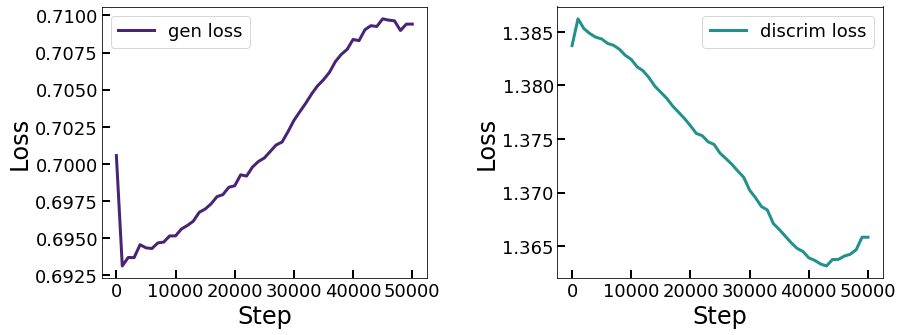

In [11]:
gen_loss = losses[0]
discrim_loss = losses[1]
n = len(gen_loss)
batches = np.arange(n)*1000

fig, axes = plt.subplots(figsize=(14,5), ncols=2)
plt.subplots_adjust(wspace=0.4)

axes[0].plot(batches, gen_loss, c=plt.cm.viridis(0.1),
             linewidth=3, label='gen loss')
axes[1].plot(batches, discrim_loss, c=plt.cm.viridis(0.5),
             linewidth=3, label='discrim loss')

for ax in axes:
    ax.set_xlabel('Step', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    
    plt.setp(ax.get_xticklabels(), fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.legend(fontsize=18)

plt.show()

## <p style="text-align: center;"> Predict </p>

###  <p style="text-align: center;">Hyperparam options</p>

#### Prediction:
- ```num_predictions=100```

    (Number of predictions to make in order to sample uncertainties.)

In [12]:
uc_threshold = 0.05
preds, uncs, flags = GAN.predict(Xs_test, uc_threshold = uc_threshold)
print(np.average(uncs))

0.07762911075762674


In [13]:
# inverses transform y data
preds = preds*SCALE
Ys_test = Ys_test*SCALE

## <p style="text-align: center;"> Results </p>

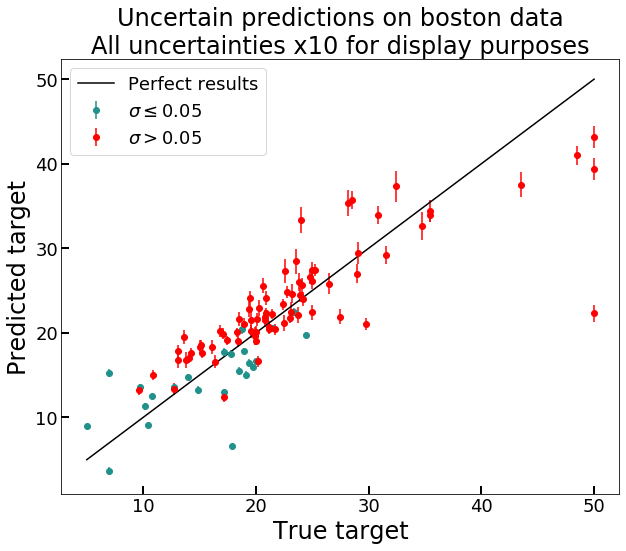

In [14]:
# figure
fig, ax = plt.subplots(figsize=(10,8))

# plotting predicted vs true
# scatter
ax.errorbar(Ys_test.reshape(-1,1)[np.invert(flags)], preds[np.invert(flags)],
            yerr = 10*uncs[np.invert(flags)], ls='none',
            c=plt.cm.viridis(0.5), marker='o',
            label=f'$\sigma \leq {uc_threshold}$')

ax.errorbar(Ys_test.reshape(-1,1)[flags], preds[flags],
            yerr = 10*uncs[flags], ls='none',
            c='r', marker='o',
            label=f'$\sigma > {uc_threshold}$')

min_y, max_y = np.min(Ys_test.reshape(-1,1)), np.max(Ys_test.reshape(-1,1))
# perfect results
x = np.linspace(min_y, max_y, 100)
ax.plot(x, x, 'k-', label= "Perfect results")

# axes labels formatting
ax.set_xlabel('True target', fontsize=24)
ax.set_ylabel('Predicted target', fontsize=24)

# tick formatting
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

# legend & title
plt.legend(fontsize=18)
plt.title('Uncertain predictions on boston data\nAll uncertainties x10 for display purposes', size=24)
plt.show()

In [15]:
import altair as alt
import pandas as pd

df = pd.DataFrame({'preds': preds.squeeze(), 'true': Ys_test.squeeze(), 'uncs': uncs.squeeze()})

alt.Chart(df).mark_point().encode(
    x='true',
    y='preds',
    size='uncs:Q',
    color='uncs:Q'
)

alt.Chart(...)

In [16]:
GAN.save('test_gan.h5')

In [17]:
GAN = gans.GAN.load('test_gan.h5')